# Classificação de sequências utilizando redes LSTM do Keras

### Depois de completar este tutorial, saberemos melhor como:

Fonte: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

- Como desenvolver um modelo LSTM para classificar sequências
- Como reduzir o overfitting nos modelos LSTM usando o dropout
- Como combinar modelos LSTM com CNN (Redes Neurais Convolucionais) que se destacam na aprendizagem de relações espaciais.

## Descrição do problema:

Dataset disponível em: http://ai.stanford.edu/~amaas/data/sentiment/

- Dado uma crítica de um filme, classificar se essa crítica é positiva ou negativa
- O dataset contém 50 mil críticas, metade para treino e metade para validação e teste (50% - 25% - 25%) 


In [1]:
import numpy

import tensorflow as tf

from keras.datasets import imdb

from keras.models import Sequential

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.preprocessing import sequence

from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

# fix random seed for reproducibility
numpy.random.seed(42)

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

BATCH_SIZE = 128 * tpu_strategy.num_replicas_in_sync

Using TensorFlow backend.


### Lendo o dataset
- A API do Keras fornece este dataset já transformado em um formato que pode ser utilizado em Redes Neurais
- Retornando 50% para treino e 50% para teste
- As palavras foram substituídas por números inteiros que indicam a frequência ordenada de cada palavra no conjunto de dados. As sentenças em cada revisão são, portanto, compostas por uma sequência de números inteiros.
- Iremos utilizar apenas as 5 mil palavras mais usadas do Dataset

In [2]:
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=.5)

17465344/17464789 [==============================] - 1s 0us/step


### Tratando o tamanho variado das sequencias
- Iremos definir o tamanho fixo do vetor de palavras
    - Truncando as críticas com mais de 500 palavras 
    - Utilizando uma função de PAD para deixar as crítcas que utilizam menos de 500 palavras em um vetor de tamanho 500  
     - A função de PAD move todas as palavras para esquerda e preenche os aspaços vazios com 0s
- O modelo irá entender que o 0 não carrega informação, portando ele irá entender que as sequencias não são do mesmo tamanho, mas vetores de tamanhos iguais são necessários para realizar o processamento atravéz do Keras. 

In [3]:
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
X_validation = sequence.pad_sequences(X_validation, maxlen=max_review_length)

Foi definido um EarlyStopping para ele parar antes das 10 épocas caso o modelo não melhore como esperado

In [4]:
callback_early = EarlyStopping(min_delta=0.01, patience=3)

### Definindo um modelo básico LSTM

Mapearemos cada crítica de filme em um vetor de números reais, uma técnica muito utilizada ao trabalhar com texto chamado **word embedding**. 

Essa tenica codifica as palavras como vetores com valores reais onde a semelhança entre as palavras em termos de significado se traduz em proximidade no espaço vetorial.

O Keras fornece uma maneira conveniente de converter as palavras em representações inteiras positivas com uma **Embedding Layer**

#### Arquitetura da rede:
- A primeira camada é uma Embedding layer que usa um vetor de 32 posições para representar cada palavra
- Depois uma camada LSTM com 100 unidades de memória (neurônios inteligentes: saída)
- Finalmente, como esse é um problema de classificação, usamos uma camada de saída Densa com um único neurônio e uma função de ativação sigmóide para fazer previsões de 0 ou 1 para as duas classes (boas ou ruins) do problema.

In [5]:
# create the model
with tpu_strategy.scope():    
    embedding_vector_length = 32
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________


In [6]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=10, batch_size=BATCH_SIZE, callbacks=[callback_early])

Train on 25000 samples, validate on 12500 samples
Epoch 1/10
25000/25000 [==============================] - 54s 2ms/step - loss: 0.6962 - accuracy: 0.5857 - val_loss: 0.6651 - val_accuracy: 0.7326
Epoch 2/10
25000/25000 [==============================] - 53s 2ms/step - loss: 0.6466 - accuracy: 0.7487 - val_loss: 0.5282 - val_accuracy: 0.8006
Epoch 3/10
25000/25000 [==============================] - 52s 2ms/step - loss: 0.4564 - accuracy: 0.8087 - val_loss: 0.4021 - val_accuracy: 0.8309
Epoch 4/10
25000/25000 [==============================] - 54s 2ms/step - loss: 0.3323 - accuracy: 0.8644 - val_loss: 0.3323 - val_accuracy: 0.8581
Epoch 5/10
25000/25000 [==============================] - 53s 2ms/step - loss: 0.3014 - accuracy: 0.8798 - val_loss: 0.3181 - val_accuracy: 0.8668
Epoch 6/10
25000/25000 [==============================] - 53s 2ms/step - loss: 0.2439 - accuracy: 0.9064 - val_loss: 0.3046 - val_accuracy: 0.8756
Epoch 7/10
25000/25000 [==============================] - 53s 2ms/st

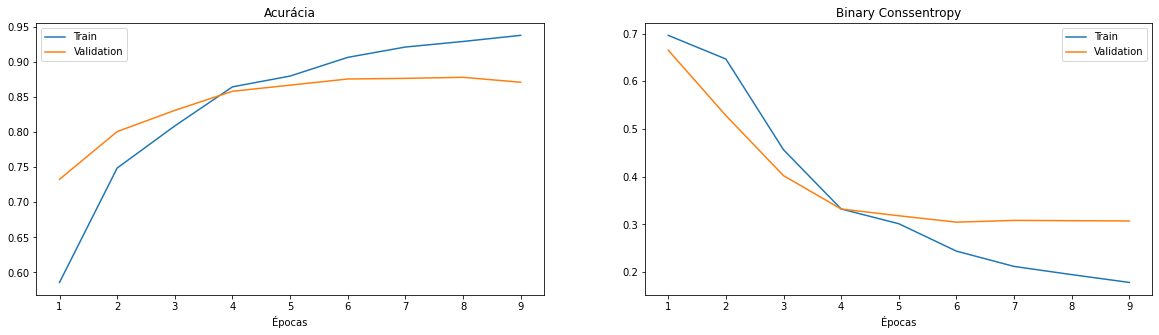

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title('Acurácia')
ax[0].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label="Train")
ax[0].plot(range(1, len(history.history['accuracy']) + 1), history.history['val_accuracy'], label="Validation")
ax[0].legend()
ax[0].set_xlabel('Épocas')
ax[0].set_xticks(range(1, len(history.history['accuracy']) + 1))
ax[1].set_title('Binary Conssentropy')
ax[1].plot(range(1, len(history.history['accuracy']) + 1), history.history['loss'], label="Train")
ax[1].plot(range(1, len(history.history['accuracy']) + 1), history.history['val_loss'], label="Validation")
ax[1].legend()
ax[1].set_xlabel('Épocas')
ax[1].set_xticks(range(1, len(history.history['accuracy']) + 1))
plt.show()

In [8]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 87.78%


Podemos observar que já obtemos um bom resultado criando uma rede bem simples

In [9]:
model.save('simple_LSTM.h5')

###  Rede LSTM para classificação de sequência utilizando o Dropout
Redes neurais como LSTM geralmente têm problemas com Overfitting.
O Keras disponibiliza camadas **Dropout** para resolver este tipo de problema.

Adicionaremos camadas dropout entre as camadas da nossa rede criada

In [10]:
with tpu_strategy.scope():
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________


In [11]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=BATCH_SIZE, callbacks=[callback_early])

Train on 25000 samples, validate on 12500 samples
Epoch 1/10
25000/25000 [==============================] - 54s 2ms/step - loss: 0.6794 - accuracy: 0.5815 - val_loss: 0.6364 - val_accuracy: 0.6586
Epoch 2/10
25000/25000 [==============================] - 53s 2ms/step - loss: 0.6463 - accuracy: 0.6814 - val_loss: 0.6329 - val_accuracy: 0.6917
Epoch 3/10
25000/25000 [==============================] - 53s 2ms/step - loss: 0.5538 - accuracy: 0.7556 - val_loss: 0.4871 - val_accuracy: 0.7810
Epoch 4/10
25000/25000 [==============================] - 53s 2ms/step - loss: 0.4544 - accuracy: 0.8021 - val_loss: 0.5053 - val_accuracy: 0.7752
Epoch 5/10
25000/25000 [==============================] - 53s 2ms/step - loss: 0.4142 - accuracy: 0.8247 - val_loss: 0.3710 - val_accuracy: 0.8383
Epoch 6/10
25000/25000 [==============================] - 55s 2ms/step - loss: 0.3081 - accuracy: 0.8732 - val_loss: 0.3310 - val_accuracy: 0.8605
Epoch 7/10
25000/25000 [==============================] - 53s 2ms/st

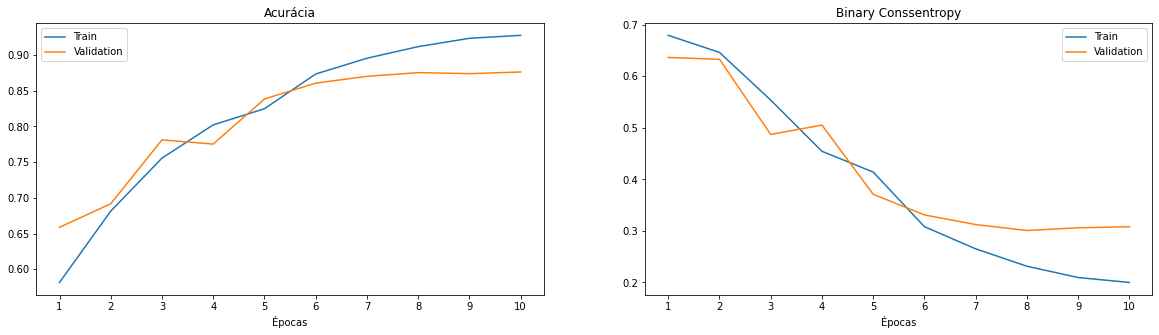

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title('Acurácia')
ax[0].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label="Train")
ax[0].plot(range(1, len(history.history['accuracy']) + 1), history.history['val_accuracy'], label="Validation")
ax[0].legend()
ax[0].set_xlabel('Épocas')
ax[0].set_xticks(range(1, len(history.history['accuracy']) + 1))
ax[1].set_title('Binary Conssentropy')
ax[1].plot(range(1, len(history.history['accuracy']) + 1), history.history['loss'], label="Train")
ax[1].plot(range(1, len(history.history['accuracy']) + 1), history.history['val_loss'], label="Validation")
ax[1].legend()
ax[1].set_xlabel('Épocas')
ax[1].set_xticks(range(1, len(history.history['accuracy']) + 1))
plt.show()

In [13]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 87.61%


Podemos observar neste exemplo que a acurácia do treinamento tem uma tendência um pouco mais lenta na convergência, mas não conseguiu apresentar uma melhor performance. 

O Dropout é considerada uma uma técnica poderosa para tratar o Overfitting.

In [14]:
model.save('layer_wise_dropout_LSTM.h5')

Como alternativa, o Dropout pode ser aplicado à entrada e suas respectivas conexões recorrentes das unidades de memória do LSTM de forma precisa e separada.

In [15]:
with tpu_strategy.scope():
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=BATCH_SIZE, callbacks=[callback_early])

Train on 25000 samples, validate on 12500 samples
Epoch 1/10
25000/25000 [==============================] - 57s 2ms/step - loss: 0.6834 - accuracy: 0.5944 - val_loss: 0.6548 - val_accuracy: 0.7169
Epoch 2/10
25000/25000 [==============================] - 56s 2ms/step - loss: 0.5659 - accuracy: 0.7546 - val_loss: 0.4386 - val_accuracy: 0.8186
Epoch 3/10
25000/25000 [==============================] - 56s 2ms/step - loss: 0.4271 - accuracy: 0.8214 - val_loss: 0.3948 - val_accuracy: 0.8343
Epoch 4/10
25000/25000 [==============================] - 56s 2ms/step - loss: 0.3747 - accuracy: 0.8464 - val_loss: 0.3567 - val_accuracy: 0.8487
Epoch 5/10
25000/25000 [==============================] - 56s 2ms/step - loss: 0.3444 - accuracy: 0.8616 - val_loss: 0.3390 - val_accuracy: 0.8532
Epoch 6/10
25000/25000 [==============================] - 57s 2ms/step - loss: 0.3127 - accuracy: 0.8754 - val_loss: 0.3236 - val_accuracy: 0.8674
Epoch 7/10
25000/25000 [==============================] - 56s 2ms/st

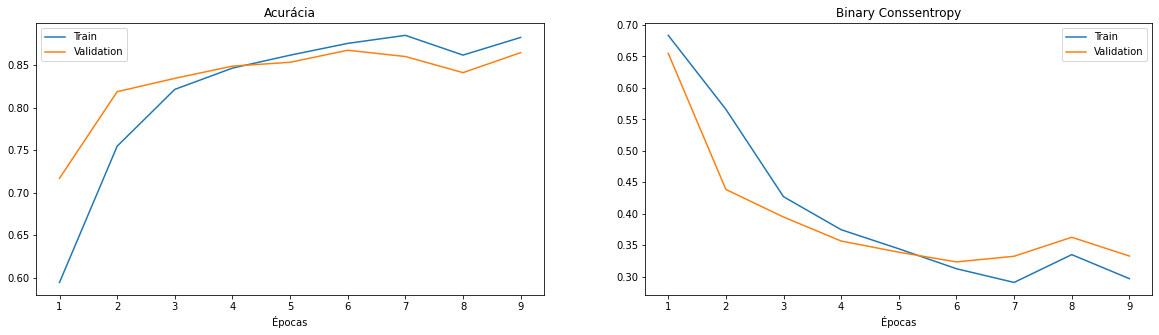

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title('Acurácia')
ax[0].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label="Train")
ax[0].plot(range(1, len(history.history['accuracy']) + 1), history.history['val_accuracy'], label="Validation")
ax[0].legend()
ax[0].set_xlabel('Épocas')
ax[0].set_xticks(range(1, len(history.history['accuracy']) + 1))
ax[1].set_title('Binary Conssentropy')
ax[1].plot(range(1, len(history.history['accuracy']) + 1), history.history['loss'], label="Train")
ax[1].plot(range(1, len(history.history['accuracy']) + 1), history.history['val_loss'], label="Validation")
ax[1].legend()
ax[1].set_xlabel('Épocas')
ax[1].set_xticks(range(1, len(history.history['accuracy']) + 1))
plt.show()

In [18]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 86.46%


Podemos perceber que o resultado não foi tão bom quanto os outros modelos.

In [19]:
model.save('LSMT_dropout.h5')

### LSTM e Convolutional Neural Network (CNN) para classificação de sequências

As redes neurais convolucionais são excelentes em aprender a estrutura espacial dos dados de entrada.

Os dados das críticas do IMDB têm uma estrutura espacial unidimensional (Uma sequência de palavras). A CNN pode ser capaz de escolher características relevantes para classificação positivas ou negativas.

As características espaciais aprendidas pela CNN podem ser aprendidos como sequências por uma camada LSTM.

Podemos facilmente adicionar uma CNN unidimensional eu uma camada **MaxPooling** depois de uma Embedding Layer e usar o resultado como entrada para a camda LSTM.

A camada MaxPooling diminui a dimensionalidade dos vetores minimizando a perda de informação para o aprendizado. Serve para resumir a presença das features de entrada.

In [20]:
with tpu_strategy.scope():
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_review_length))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 216,405
Trainable params: 216,405
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=BATCH_SIZE, callbacks=[callback_early])

Train on 25000 samples, validate on 12500 samples
Epoch 1/10
25000/25000 [==============================] - 28s 1ms/step - loss: 0.6748 - accuracy: 0.5746 - val_loss: 0.6231 - val_accuracy: 0.6166
Epoch 2/10
25000/25000 [==============================] - 28s 1ms/step - loss: 0.5884 - accuracy: 0.7398 - val_loss: 0.5302 - val_accuracy: 0.7851
Epoch 3/10
25000/25000 [==============================] - 27s 1ms/step - loss: 0.5451 - accuracy: 0.7537 - val_loss: 0.5230 - val_accuracy: 0.7956
Epoch 4/10
25000/25000 [==============================] - 27s 1ms/step - loss: 0.4116 - accuracy: 0.8362 - val_loss: 0.3487 - val_accuracy: 0.8536
Epoch 5/10
25000/25000 [==============================] - 27s 1ms/step - loss: 0.2746 - accuracy: 0.8868 - val_loss: 0.2976 - val_accuracy: 0.8752
Epoch 6/10
25000/25000 [==============================] - 27s 1ms/step - loss: 0.2220 - accuracy: 0.9130 - val_loss: 0.2793 - val_accuracy: 0.8835
Epoch 7/10
25000/25000 [==============================] - 27s 1ms/st

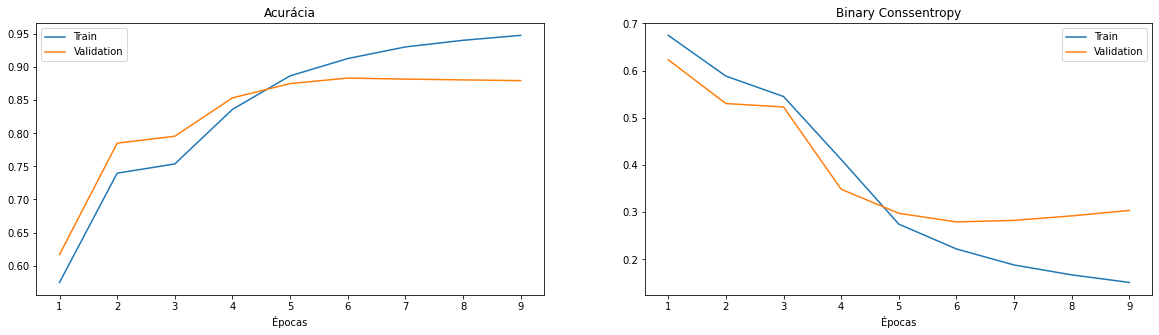

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title('Acurácia')
ax[0].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'], label="Train")
ax[0].plot(range(1, len(history.history['accuracy']) + 1), history.history['val_accuracy'], label="Validation")
ax[0].legend()
ax[0].set_xlabel('Épocas')
ax[0].set_xticks(range(1, len(history.history['accuracy']) + 1))
ax[1].set_title('Binary Conssentropy')
ax[1].plot(range(1, len(history.history['accuracy']) + 1), history.history['loss'], label="Train")
ax[1].plot(range(1, len(history.history['accuracy']) + 1), history.history['val_loss'], label="Validation")
ax[1].legend()
ax[1].set_xlabel('Épocas')
ax[1].set_xticks(range(1, len(history.history['accuracy']) + 1))
plt.show()

In [23]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 87.97%


Podemos perceber que obtemos um resultado similar ao do primeiro exemplo, porém foi bem mais rápido realizar ao realziar a execução.

Podemos experimentar colocar o Dropout nesta ultima rede. Para ver como ela irá se comportar.

In [24]:
model.save('LSMT_CNN.h5')